# Machine translation with RNNs

In the previous lab, we have seen how to load and preprocess a text dataset, as well as the basics of RNNs. We also implemented the encoder of a machine translation network. In this lab, we code the decoder and the full model, and we train it on our dataset.

<center><a href="https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html">
    <img src="https://pytorch.org/tutorials/_images/seq2seq.png" width="500"></a></center>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import time
import spacy
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import copy

## Dataset and preprocessing

All the preprocessing part is the same as in the previous lab (except we also load a validation set), so we directly provide the code here.

In [2]:
# German and English specific pipelines
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

# Tokenizers
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

# Fields
SRC = Field(tokenize=tokenize_de, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

# Dataset
train_data, valid_data, test_data = Multi30k.splits(root='data/', exts = ('.de', '.en'), fields = (SRC, TRG))

# We take a subset of the full dataset for speed
train_data.examples = train_data.examples[:1000]
valid_data.examples = valid_data.examples[:100]
test_data.examples = train_data.examples[:100]

# Vocabulary
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

# Dataloader (here we keep the validation dataloader)
batch_size = 128
train_dataloader, valid_dataloader, test_dataloader = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size = batch_size)

In [3]:
# Index to string functions
def indx2tokens_list(list_indx, field):
    list_tokens = [field.vocab.itos[list_indx[i]] for i in range(len(list_indx))]
    beg_i = list_tokens.index('<sos>')
    if '<eos>' in list_tokens:
        end_i = list_tokens.index('<eos>')
    else:
        end_i = -1
    list_tokens = list_tokens[beg_i+1:end_i]
    return list_tokens

In [4]:
# Get an example batch
example_batch = next(iter(train_dataloader))
example_batch_src, example_batch_trg = example_batch.src, example_batch.trg

## Seq2seq model

Let's remind the overall structure of the machine translation model. This model is based on two parts:

- an *encoder*, which takes as input the source sentence (in German) and encodes it into a *context* vector. This context vector is sort of a summary of the whole input sentence.
- a *decoder*, which takes as input this context vector and sequentially generates a sentence in English. It always starts with the `<sos>` token and uses the context vector to generate the second token. Then, it recursively uses the last produced token and the hidden state to generate the next token.

<center><a href="https://github.com/bentrevett/pytorch-seq2seq">
    <img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013//assets/seq2seq1.png"></a></center>


### Encoder

We provide the encoder below. It is very similar to the encoder written in lab 7, except it uses a 2-layer LSTM with recurrent dropout.

In [5]:
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        self.input_size = input_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding_layer = nn.Embedding(input_size, emb_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers, dropout=dropout_rate)
        
    def forward(self, src):
                                            
        y = self.embedding_layer(src)
        y = self.dropout(y)
        _, (hidden, cell) = self.lstm(y)
                                            
        return hidden, cell

In [6]:
# Parameters
input_size = len(SRC.vocab)
emb_size_enc = 32
hidden_size = 50
n_layers = 2
dropout_rate = 0.5

# Instanciate the encoder and print the number of trainable parameters
encoder_lstm = LSTMEncoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
print('Number of parameters:', sum(p.numel() for p in encoder_lstm.parameters()))

# Apply it to the example batch
enc_hidden, enc_cell = encoder_lstm(example_batch_src)
print(enc_hidden.shape)
print(enc_cell.shape)

Number of parameters: 62864
torch.Size([2, 128, 50])
torch.Size([2, 128, 50])


### Decoder

Now, let's build the decoder. We treat machine translation as a classification task: the decoder tries to predict the probability of all token indices in the output (target) vocabulary from an input token index. This has two implications:

- In addition to the embedding, dropout and LSTM layers, the decoder applies an extra linear layer/MLP to perform prediction of the probabilities. Therefore, this linear layer goes from a space of size `hidden_size_dec` to a space of size `output_size`, which is the number of tokens in the target vocabulary.
- the decoder doesn't process all the sentence at once, but instead it processes tokens one by one, since the input at step $t$ is the word that has been predicted at step $t-1$ (not just the hidden state). Therefore, the input to the decoder has a sequence length of 1 (the recursive calculation over the whole sentence will be done in the full model).

In [7]:
class LSTMDecoder(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        # TO DO:
        # - store the attributes
        # - create the embedding, dropout, and LSTM layers (it uses recurrent dropout)
        # - create the linear layer (it goes from a space of size 'hidden_size' to 'output_size')
        self.output_size = output_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.embedding_layer = nn.Embedding(output_size, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, n_layers,dropout=dropout_rate)
        self.linear_layer = nn.Linear(hidden_size, output_size)

    def forward(self, input_idx, input_hidden, input_cell):
        
        # apply the embedding and dropout layers
        y = self.dropout_layer(self.embedding_layer(input_idx))
        
        # since y has a shape [batch_size, hidden_size], we need to unsqueeze it
        # to create an artificial 'seq_length' (=1) dimension
        y = y.unsqueeze(0)
        
        # TO DO:
        # - apply the LSTM layer. Unlike the encoder, we need to store all the outputs to predict the target token
        # - squeeze 'output' (to remove the useless dimension 'seq_length'=1)
        # - apply the linear layer to 'output' in order to predict the probabilities
        # - return the predicted probabilities per token, and the hidden / cell states of the LSTM decoder
        output, (hidden, cell) = self.lstm(y, (input_hidden, input_cell))
        prediction = self.linear_layer(output.squeeze(0))
        return prediction, hidden, cell

In [8]:
# Define the decoder parameters
output_size = len(TRG.vocab)
emb_size_dec = 32

# Instanciate the decoder and print the number of trainable parameters
decoder_lstm = LSTMDecoder(output_size, emb_size_dec, hidden_size, n_layers, dropout_rate)
print('Number of parameters:', sum(p.numel() for p in decoder_lstm.parameters()))

# Create an artificial numerized input token (input indices) with value '2'
# (it corresponds to the 'start of sentence' or '<sos>' token)
input_idx = torch.ones(batch_size).int() * 2
# input_idx = torch.ones(batch_size).long() * 2   # depending on your torch version, it might be 'long()' instead of 'int()'

# Apply the decoder to this input token using the output of the encoder (hidden and cell)
pred_proba, dec_hidden, dec_cell = decoder_lstm(input_idx, enc_hidden, enc_cell)
print(pred_proba.shape)
print(dec_hidden.shape)
print(dec_cell.shape)

Number of parameters: 105509
torch.Size([128, 823])
torch.Size([2, 128, 50])
torch.Size([2, 128, 50])


In [9]:
# TO DO: from the predicted probabilities calculated before 'pred_proba', get the index with the highest probability

# TO DO: for each element in the batch, transform this index back to an actual token (word)
index_token = pred_proba.argmax(1)
token = [TRG.vocab.itos[index_token[i]] for i in range(len(index_token))]
token

['slowly',
 'slowly',
 'slowly',
 'scene',
 'slowly',
 'train',
 'slowly',
 'scene',
 'scene',
 'scene',
 'scene',
 'slowly',
 'scene',
 'scene',
 'slowly',
 'slowly',
 'golf',
 'scene',
 'slowly',
 'slowly',
 'slowly',
 'big',
 'slowly',
 'slowly',
 'scene',
 'scene',
 'firefighters',
 'his',
 'scene',
 'slowly',
 'scene',
 'scene',
 'slowly',
 'slowly',
 'scene',
 'slowly',
 'slowly',
 'slowly',
 'slowly',
 'slowly',
 'slowly',
 'big',
 'slowly',
 'scene',
 'slowly',
 'slowly',
 'scene',
 'scene',
 'slowly',
 'slowly',
 'scene',
 'scene',
 'slowly',
 'slowly',
 'slowly',
 'scene',
 'slowly',
 'ride',
 'scene',
 'slowly',
 'scene',
 'scene',
 'pot',
 'scene',
 'scene',
 'scene',
 'slowly',
 'scene',
 'slowly',
 'slowly',
 'scene',
 'beside',
 'scene',
 'slowly',
 'scene',
 'slowly',
 'slowly',
 'scene',
 'slowly',
 'slowly',
 'beside',
 'firefighters',
 'train',
 'slowly',
 'slowly',
 'scene',
 'slowly',
 'slowly',
 'scene',
 'scene',
 'ride',
 'scene',
 'slowly',
 'slowly',
 'scene',

### Full model

Finally, we need to implement the overall model, which takes an input sentence, produces the context vectors using the encoder, and produces the output sentence recursively using the decoder.

In [10]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        # Store the encoder, decoder, and the target vocabulary size
        self.encoder = encoder
        self.decoder = decoder
        self.trg_vocab_size = decoder.output_size
        
    def forward(self, src, trg_len):
        
        # Create a tensor to store the predicted probabilities from the decoder
        batch_size = src.shape[-1]
        pred_probas_all = torch.zeros(trg_len, batch_size, self.trg_vocab_size)
        
        # Assign a probability of 1 to the token corresponding to <sos> for the first element
        pred_probas_all[0, :, 2] = 1
        
        # Initialize the first input to the decoder as the <sos> token (coded by '2' in our vocabulary)
        input_idx = torch.ones(batch_size).int() * 2
        
        # TO DO: apply the encoder to the src sentence and get the last hidden and cell states (=context vectors)
        # (these will be used as initial hidden/cell for the decoder)
        hidden, cell = self.encoder(src)
        
        # loop over tokens (note that it starts from 1 -not 0- since the very first token is already known (=<sos>))
        for t in range(1, trg_len):

            # TO DO:
            # - apply the decoder to get the predicted probabilites of the token t (and the updated hidden/cell)
            # - store these predicted probabilities in the 'pred_probas_all' tensor
            # - get the index corresponding to the highest probability for this token: it will be used as the next input index
            output, hidden, cell = self.decoder(input_idx, hidden, cell)
            input_idx = output.argmax(1)
            pred_probas_all[t,:,:] = output
        return pred_probas_all

In [11]:
# Set a random seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Instanciate the model and print the number of parameters
encoder_lstm = LSTMEncoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
decoder_lstm = LSTMDecoder(output_size, emb_size_dec, hidden_size, n_layers, dropout_rate)
model_lstm = LSTMSeq2Seq(encoder_lstm, decoder_lstm)
print('Number of parameters in the LSTM model:', sum(p.numel() for p in model_lstm.parameters()))

Number of parameters in the LSTM model: 168373


<span style="color:red">**Q1**</span> How many parameters are in the LSTM Seq2seq model?

In [12]:
# TO DO: Apply the model to the 'example_batch'

# TO DO: Get the indices of highest predicted probabilities

# TO DO: Take one sample from the batch of predicted indices, and transform it back to tokens (use the indx2tokens_list function)
example_batch_src, example_batch_trg = example_batch.src, example_batch.trg
trg_len = example_batch_trg.shape[0]
probas = model_lstm(example_batch_src, trg_len)
out_probas = probas.argmax(2)
out_probas.shape
indx2tokens_list(out_probas[:,0], TRG)

['jogging',
 'boxes',
 'road',
 'boxes',
 'boxes',
 'beach',
 'road',
 'road',
 'beach',
 'boxes',
 'boxes',
 'set',
 'set',
 'boxes',
 'adults',
 'adults',
 'dock',
 'beach',
 'set',
 'set',
 'set',
 'set',
 'set']

## Training and evaluation

Now we have our model implemented, we can train it. We provide the evaluation and training with validation functions (they are very similar to what was done in previous labs).

In [69]:
def evaluate_seq2seq(model, eval_dataloader, loss_fn, SEED = 1234):

    # Set a random seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # Set the model in 'eval' mode (disable dropout layer)
    model.eval()

    # Initialize the eval loss
    loss_eval = 0

    # loop over batches
    for i, batch in enumerate(eval_dataloader):

        # Get the source and target sentence, and the target length, copy it to device
        src, trg = batch.src, batch.trg
        trg_len = trg.shape[0]

        # Apply the model
        pred_probas = model(src, trg_len)

        # Remove the first token (always <sos>) to compute the loss
        output_size = pred_probas.shape[-1]
        pred_probas = pred_probas[1:]

        # Reshape the pred_probas and target so that they have appropriate shapes:
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output_size]
        pred_probas = pred_probas.view(-1, output_size)
        trg = trg[1:].view(-1)

        # Compute the loss
        loss = loss_fn(pred_probas, trg)

        # Record the loss
        loss_eval += loss.item()

    return loss_eval

In [70]:
def training_val_seq2seq(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True, SEED = 1234):

    # Set a random seed for reproducibility
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed)
    model_tr.train()

    # define the optimizer (Adam)
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize lists for storing the train and val losses
    loss_train_total = []
    loss_val_total = []
    
    loss_val_optim = float('inf')

    for epoch in range(num_epochs):

        loss_current_epoch = 0

        for i, batch in enumerate(train_dataloader):

            # Get the source and target sentence, and the target length, copy it to device
            src, trg = batch.src, batch.trg
            trg_len = trg.shape[0]

            # Set the gradients at 0
            optimizer.zero_grad()

            # Apply the model
            pred_probas = model_tr(src, trg_len)

            # Remove the first token (always <sos>) to compute the loss
            output_dim = pred_probas.shape[-1]
            pred_probas = pred_probas[1:]

            # Reshape the pred_probas and target
            pred_probas = pred_probas.view(-1, output_dim)
            trg = trg[1:].view(-1)

            # Backpropagation
            loss = loss_fn(pred_probas, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_tr.parameters(), 1.0)
            optimizer.step()

            # Record the loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, compute the validation loss
        loss_val = evaluate_seq2seq(model_tr, valid_dataloader, loss_fn)
        
        # Record the training and validation losss over epochs
        loss_train_total.append(loss_current_epoch)
        loss_val_total.append(loss_val)
        
        # Display the training and validation losses
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f} ; Validation loss: {:.4f}'
                   .format(epoch+1, num_epochs, loss_current_epoch, loss_val))
            
        # Save the current model as optimal only if validation loss decreases
        if loss_val<loss_val_optim:
            model_opt = copy.deepcopy(model_tr)
            loss_val_optim = loss_val
                
    return model_opt, loss_train_total, loss_val_total

In [71]:
# Training parameters
learning_rate = 0.01
num_epochs = 50

# For the loss function, since we treat the problem as a classification task, we use the cross entropy.
# We also tell it to ignore the index of the <pad> token for computation speed
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
loss_fn = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# Training
model_lstm, loss_train_lstm, loss_val_lstm = training_val_seq2seq(model_lstm, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 53.5203 ; Validation loss: 6.6906
Epoch [2/50], Training loss: 53.5001 ; Validation loss: 6.6857
Epoch [3/50], Training loss: 53.4655 ; Validation loss: 6.6807
Epoch [4/50], Training loss: 53.4300 ; Validation loss: 6.6757
Epoch [5/50], Training loss: 53.3938 ; Validation loss: 6.6707
Epoch [6/50], Training loss: 53.3595 ; Validation loss: 6.6656
Epoch [7/50], Training loss: 53.3213 ; Validation loss: 6.6611
Epoch [8/50], Training loss: 53.2843 ; Validation loss: 6.6556
Epoch [9/50], Training loss: 53.2474 ; Validation loss: 6.6505
Epoch [10/50], Training loss: 53.2111 ; Validation loss: 6.6453
Epoch [11/50], Training loss: 53.1741 ; Validation loss: 6.6401
Epoch [12/50], Training loss: 53.1319 ; Validation loss: 6.6341
Epoch [13/50], Training loss: 53.0943 ; Validation loss: 6.6288
Epoch [14/50], Training loss: 53.0570 ; Validation loss: 6.6235
Epoch [15/50], Training loss: 53.0203 ; Validation loss: 6.6182
Epoch [16/50], Training loss: 52.9823 ; Validatio

## GRU network

Let us consider an alternative architecture using GRU instead of LSTM.

In [42]:
# TO DO: write the GRU encoder, decoder, and full seq2seq model. Most of the previous LSTM-related code can be reused.
# Remember that a GRU only has two outputs ('out' and 'hidden'), unlike LSTM which has an additional 'cell'.
class GRUEncoder(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        self.input_size = input_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        
        self.embedding_layer = nn.Embedding(input_size, emb_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.GRU(emb_size, hidden_size, n_layers, dropout=dropout_rate)
        
    def forward(self, src):
                                            
        y = self.embedding_layer(src)
        y = self.dropout(y)
        _, cell = self.lstm(y)
                                            
        return cell

In [43]:
input_size = len(SRC.vocab)
emb_size_enc = 32
hidden_size = 50
n_layers = 2
dropout_rate = 0.5

# Instanciate the encoder and print the number of trainable parameters
encoder_gru = GRUEncoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
print('Number of parameters:', sum(p.numel() for p in encoder_lstm.parameters()))

# Apply it to the example batch
enc_hidden = encoder_gru(example_batch_src)
print(enc_hidden.shape)

Number of parameters: 53564
torch.Size([2, 128, 50])


In [50]:
class GRUDecoder(nn.Module):
    def __init__(self, output_size, emb_size, hidden_size, n_layers, dropout_rate):
        super().__init__()
        
        # TO DO:
        # - store the attributes
        # - create the embedding, dropout, and LSTM layers (it uses recurrent dropout)
        # - create the linear layer (it goes from a space of size 'hidden_size' to 'output_size')
        self.output_size = output_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout_rate = dropout_rate
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.embedding_layer = nn.Embedding(output_size, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers,dropout=dropout_rate)
        self.linear_layer = nn.Linear(hidden_size, output_size)

    def forward(self, input_idx, input_cell):
        
        # apply the embedding and dropout layers
        y = self.dropout_layer(self.embedding_layer(input_idx))
        
        # since y has a shape [batch_size, hidden_size], we need to unsqueeze it
        # to create an artificial 'seq_length' (=1) dimension
        y = y.unsqueeze(0)
        
        # TO DO:
        # - apply the LSTM layer. Unlike the encoder, we need to store all the outputs to predict the target token
        # - squeeze 'output' (to remove the useless dimension 'seq_length'=1)
        # - apply the linear layer to 'output' in order to predict the probabilities
        # - return the predicted probabilities per token, and the hidden / cell states of the LSTM decoder
        output,  cell = self.gru(y, input_cell)
        prediction = self.linear_layer(output.squeeze(0))
        return prediction, cell

In [51]:
# Define the decoder parameters
output_size = len(TRG.vocab)
emb_size_dec = 32

# Instanciate the decoder and print the number of trainable parameters
decoder_gru = GRUDecoder(output_size, emb_size_dec, hidden_size, n_layers, dropout_rate)
print('Number of parameters:', sum(p.numel() for p in decoder_lstm.parameters()))

# Create an artificial numerized input token (input indices) with value '2'
# (it corresponds to the 'start of sentence' or '<sos>' token)
input_idx = torch.ones(batch_size).int() * 2
# input_idx = torch.ones(batch_size).long() * 2   # depending on your torch version, it might be 'long()' instead of 'int()'
print(enc_cell.shape)
# Apply the decoder to this input token using the output of the encoder (hidden and cell)
pred_proba, dec_cell = decoder_gru(input_idx, enc_hidden)
print(pred_proba.shape)
print(dec_cell.shape)

Number of parameters: 96209
torch.Size([128, 50])
torch.Size([128, 823])
torch.Size([2, 128, 50])


In [55]:
class GRUSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        # Store the encoder, decoder, and the target vocabulary size
        self.encoder = encoder
        self.decoder = decoder
        self.trg_vocab_size = decoder.output_size
        
    def forward(self, src, trg_len):
        
        # Create a tensor to store the predicted probabilities from the decoder
        batch_size = src.shape[-1]
        pred_probas_all = torch.zeros(trg_len, batch_size, self.trg_vocab_size)
        
        # Assign a probability of 1 to the token corresponding to <sos> for the first element
        pred_probas_all[0, :, 2] = 1
        
        # Initialize the first input to the decoder as the <sos> token (coded by '2' in our vocabulary)
        input_idx = torch.ones(batch_size).int() * 2
        
        # TO DO: apply the encoder to the src sentence and get the last hidden and cell states (=context vectors)
        # (these will be used as initial hidden/cell for the decoder)
        cell = self.encoder(src)
        
        # loop over tokens (note that it starts from 1 -not 0- since the very first token is already known (=<sos>))
        for t in range(1, trg_len):

            # TO DO:
            # - apply the decoder to get the predicted probabilites of the token t (and the updated hidden/cell)
            # - store these predicted probabilities in the 'pred_probas_all' tensor
            # - get the index corresponding to the highest probability for this token: it will be used as the next input index
            output, cell = self.decoder(input_idx, cell)
            input_idx = output.argmax(1)
            pred_probas_all[t,:,:] = output
        return pred_probas_all

In [56]:
# Set a random seed for reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Instanciate the GRU model
encoder_gru = GRUEncoder(input_size, emb_size_enc, hidden_size, n_layers, dropout_rate)
decoder_gru = GRUDecoder(output_size, emb_size_dec, hidden_size, n_layers, dropout_rate)
model_gru = GRUSeq2Seq(encoder_gru, decoder_gru)

# Number of parameters
print('Number of parameters in the GRU model:', sum(p.numel() for p in model_gru.parameters()))

Number of parameters in the GRU model: 149773


<span style="color:red">**Q2**</span> How many parameters are in the GRU Seq2seq model?

In [67]:
# TO DO: pass the example batch to the GRU model and print the size of the output ('pred_probas_all')
example_batch_src, example_batch_trg = example_batch.src, example_batch.trg
trg_len = example_batch_trg.shape[0]
probas = model_gru(example_batch_src, trg_len)
out_probas = probas.argmax(2)
print(probas.shape)
indx2tokens_list(out_probas[:,0], TRG)

torch.Size([25, 128, 823])


['a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a']

In [63]:
# TO DO: train the GRU model
# Training parameters
learning_rate = 0.01
num_epochs = 50

# For the loss function, since we treat the problem as a classification task, we use the cross entropy.
# We also tell it to ignore the index of the <pad> token for computation speed
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
loss_fn = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# Training
model_gru, loss_train_gru, loss_val_gru = training_val_seq2seq(model_gru, train_dataloader, 
                            valid_dataloader, 
                            num_epochs, loss_fn, learning_rate)

Epoch [1/50], Training loss: 53.7499 ; Validation loss: 6.7231
Epoch [2/50], Training loss: 53.7045 ; Validation loss: 6.7070
Epoch [3/50], Training loss: 53.6184 ; Validation loss: 6.6949
Epoch [4/50], Training loss: 53.5572 ; Validation loss: 6.6861
Epoch [5/50], Training loss: 53.5126 ; Validation loss: 6.6818
Epoch [6/50], Training loss: 53.4773 ; Validation loss: 6.6827
Epoch [7/50], Training loss: 53.4030 ; Validation loss: 6.6665
Epoch [8/50], Training loss: 53.3428 ; Validation loss: 6.6632
Epoch [9/50], Training loss: 53.2746 ; Validation loss: 6.6445
Epoch [10/50], Training loss: 53.2574 ; Validation loss: 6.6513
Epoch [11/50], Training loss: 53.1942 ; Validation loss: 6.6406
Epoch [12/50], Training loss: 53.1265 ; Validation loss: 6.6314
Epoch [13/50], Training loss: 53.0628 ; Validation loss: 6.6229
Epoch [14/50], Training loss: 52.9929 ; Validation loss: 6.6144
Epoch [15/50], Training loss: 52.9238 ; Validation loss: 6.6007
Epoch [16/50], Training loss: 52.8752 ; Validatio

## Comparing the LSTM and GRU models

Finally, let us compare the two proposed architectures.

In [64]:
# TO DO: print the number of parameters of both models (already done above)
print('Number of parameters in the LSTM model:', sum(p.numel() for p in model_lstm.parameters()))
print('Number of parameters in the GRU model:', sum(p.numel() for p in model_gru.parameters()))

Number of parameters in the LSTM model: 168373
Number of parameters in the GRU model: 149773


<Figure size 1000x1000 with 0 Axes>

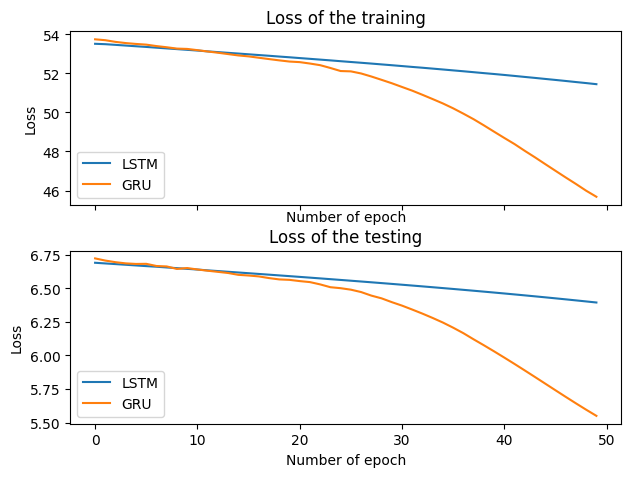

In [97]:
#TO DO: plot the training and validation losses for both models
# - one subplot will contain the training loss
# - the other subplot represents the validation loss
plt.figure(figsize=(10,10))
f, (ax1, ax2) = plt.subplots(2, 1, sharex="col")
ax1.plot(range(num_epochs),loss_train_lstm, label="LSTM")
ax1.plot(range(num_epochs), loss_train_gru, label="GRU")
ax1.set(xlabel='Number of epoch', ylabel='Loss',
       title='Loss of the training')
ax1.legend()
f.tight_layout(pad=1.5)
ax2.plot(range(num_epochs), loss_val_lstm,label="LSTM")
ax2.plot(range(num_epochs), loss_val_gru, label="GRU")
ax2.set(xlabel='Number of epoch', ylabel='Loss',
       title='Loss of the testing')
ax2.legend()
plt.show()

In [102]:
# TO DO: compute and print the test loss for both models
print(f"LSTM Loss : {evaluate_seq2seq(model_lstm, test_dataloader, loss_fn, SEED = 1234):0.3f}")
print(f"GRU Loss : {evaluate_seq2seq(model_gru, test_dataloader, loss_fn, SEED = 1234):0.3f}")

LSTM Loss : 6.424
GRU Loss : 5.676


<span style="color:red">**Q3**</span> Place these results (number of parameters, training log, and test loss) in your report. Based on these, which network would you recommend to use?